# Bitki Yaprak Hastaligi Siniflandirma (PlantVillage)

**Ogrenci:** Omar A.M Issa  **Ogrenci No:** 220212901

Bu not defteri, PlantVillage veri seti ile yaprak hastaligi siniflandirmasini uctan uca ele alir. Kodlar Python olarak korunur, aciklamalar Turkcedir. Akis olarak once veriyi indirip duzenliyoruz, sonra veri yapisini ve dagilimi kontrol ediyoruz, ardindan klasik bir temel model kurup en son transfer ogrenme ile daha guclu bir model karsilastiriyoruz. Bu sirayi takip etmemin nedeni, veri problemlerini (dengesizlik, bozuk dosya vb.) erken gormezsem model sonuclarini yanlis yorumlama riskimin artmasidir.


## 1. Giris
Bu calismada hedefim: PlantVillage yaprak goruntulerinden hastalik sinifini tahmin etmek. Bu problem tarimda erken tespit icin onemli, cunku gec tespit hem verimi dusurur hem de ilaclama maliyetini artirir.
Akis: veri setini tanimla -> sinif dagilimi ve ornek goruntuler ile ilk kontrol -> bozuk veri kontrolu -> tekrarlanabilirlik ayarlari -> veri hazirlama (transform/augmentation) -> HOG+SVM temel modeli -> ResNet-18 transfer ogrenme -> hiperparametre taramasi -> detayli degerlendirme.
Bu siralama mantikli cunku veri hazirlamadan model kurmak yaniltici olur, once veri kalitesini netlestirmek gerekir.


## 2. Veri Seti Tanimi
- Kaynak: TensorFlow Datasets (plant_village/plantvillage) ve Kaggle (emmarex/plantdisease).
- Lisans: Kaynak sayfalarinda belirtilen lisans kosullari gecerli; bu calisma akademik/egitim amaclidir.
- Etiketler: Her sinif bitki turu + hastalik durumu (saglikli/hastalikli) seklindedir. Ornek sinif: Background_without_leaves, Tomato___Early_blight.

Bu bolumden hemen sonra veriyi disk uzerinde hazirlayip bolmelere ayiriyorum. Bunun icin `src.data` icindeki `prepare_dataset`, `get_split_paths`, `get_class_names` fonksiyonlarini kullanacagim; amacim once sinif isimlerini ve dosya yollarini netlestirip EDA adimlarina saglam bir temel atmak. Grafikler icin `matplotlib`/`seaborn`, tablolama icin `pandas`, goruntu okumak icin `PIL.Image` kullaniyorum.


In [1]:
import os
import sys
from pathlib import Path
from collections import Counter

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src import config
from src.data import prepare_dataset, get_split_paths, get_class_names
from src.viz import plot_class_distribution, save_image_grid

sns.set_theme(style="whitegrid")

processed_root = prepare_dataset()
class_names = get_class_names(processed_root)

train_paths, train_labels = get_split_paths(processed_root, "train")
val_paths, val_labels = get_split_paths(processed_root, "val")
test_paths, test_labels = get_split_paths(processed_root, "test")

split_sizes = {
    "train": len(train_paths),
    "val": len(val_paths),
    "test": len(test_paths),
}


def build_split_count_df(labels, split_name):
    counts = pd.Series(labels).value_counts().sort_index()
    return pd.DataFrame({"sinif": counts.index, split_name: counts.values})


counts_df = build_split_count_df(train_labels, "train")
counts_df = counts_df.merge(build_split_count_df(val_labels, "val"), on="sinif", how="left")
counts_df = counts_df.merge(build_split_count_df(test_labels, "test"), on="sinif", how="left")
counts_df = counts_df.fillna(0).astype({"train": int, "val": int, "test": int})

split_sizes, counts_df.head()


({'train': 19862, 'val': 4256, 'test': 4257},
                        sinif  train  val  test
 0         Apple___Apple_scab    441   95    94
 1          Apple___Black_rot    435   93    93
 2   Apple___Cedar_apple_rust    193   41    41
 3            Apple___healthy   1151  247   247
 4  Background_without_leaves    800  171   172)

### 2.1 Sinif Dagilimi
Bu hucrede hedefim, her sinifta kac ornek oldugunu sayip dengesizligi erken gormek. Sayim icin `pandas.Series.value_counts()` kullaniyorum; bu fonksiyon sinif etiketlerini hizli sekilde sayar. Gorsellestirme icin `seaborn.barplot()` ve `matplotlib.pyplot.figure()` kullaniliyor; bu ikisi ile bar grafikleri daha okunur hale geliyor. Ek olarak `src.viz.plot_class_distribution` ile ayni grafiği `outputs/` altina kaydetmis oluyorum. Bu adim, model kurmadan once "hangi siniflari daha dikkatli yorumlamaliyim" sorusunu cevaplamama yardim eder.


C:\Users\pc\AppData\Local\Temp\ipykernel_14672\340115894.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


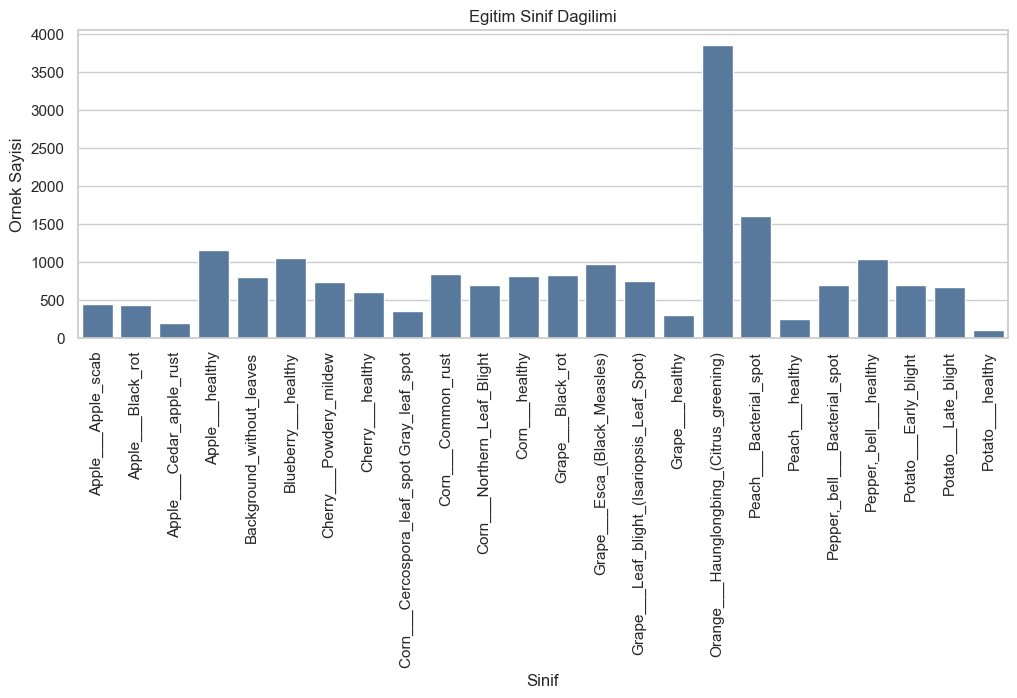

In [2]:
plt.figure(figsize=(12, 4))
train_counts = pd.Series(train_labels).value_counts().sort_index()
sns.barplot(x=train_counts.index, y=train_counts.values, color="#4C78A8")
plt.title("Egitim Sinif Dagilimi")
plt.xlabel("Sinif")
plt.ylabel("Ornek Sayisi")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plot_class_distribution(train_labels, config.FIGURES_DIR / "class_distribution.png")


Siniflarin sayisal dagilimi goruldugunde dengesiz siniflarin varligi kolayca fark edilir. Barlar birbirine yakin ise veri daha dengeli ve bu iyi bir isarettir; cok buyuk farklar varsa modelin az ornekli siniflarda zorlanmasi beklenir. Dengesizlik varsa daha sonra metrikleri (ozellikle macro F1) yorumlarken dikkatli olmaliyim ve gerekirse agirlikli kayip veya veri arttirma dusunmeliyim.


### 2.2 Ornek Goruntu Gridi
Burada amacim rastgele birkac goruntuyu yan yana gormek ve veri kalitesini gozle kontrol etmek. `PIL.Image.open()` ile resimleri okuyup `matplotlib.pyplot.subplots()` ile bir grid olusturuyorum. Kendi yazdigim `plot_image_grid` fonksiyonu bu islemi tekrar kullanilabilir hale getiriyor; fonksiyonun isi, goruntuyu gosterip basliga sinif etiketini yazmak. Bu adimi sinif dagilimindan hemen sonra yapiyorum cunku sayilari gordukten sonra "goruntuler gercekten bekledigim gibi mi?" sorusunu gorsel olarak onaylamak istiyorum.


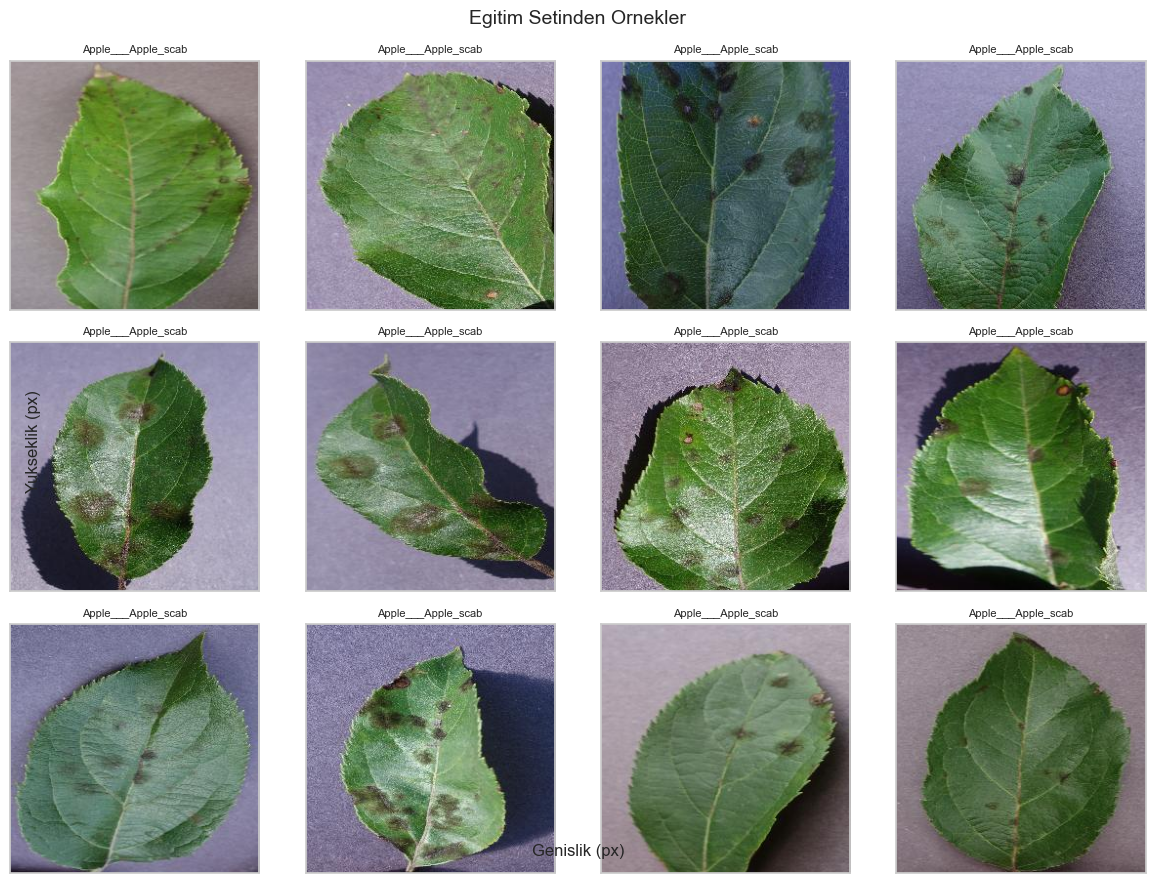

In [3]:
def plot_image_grid(image_paths, labels, rows=3, cols=4, title="Ornek Goruntu Gridi"):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    for ax, path, label in zip(axes.ravel(), image_paths[: rows * cols], labels[: rows * cols]):
        img = Image.open(path).convert("RGB")
        ax.imshow(img)
        ax.set_title(label, fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(title, fontsize=14)
    fig.text(0.5, 0.04, "Genislik (px)", ha="center")
    fig.text(0.04, 0.5, "Yukseklik (px)", va="center", rotation="vertical")
    plt.tight_layout()
    plt.show()


plot_image_grid(train_paths, train_labels, rows=3, cols=4, title="Egitim Setinden Ornekler")

save_image_grid(train_paths, config.FIGURES_DIR / "sample_grid.png")


Ornek goruntuler, siniflar arasindaki renk, doku ve sekil farklarini niteliksel olarak gosterir. Goruntuler net ve sinif etiketiyle uyumluysa bu iyi bir isarettir; cok bulanik, arka plan agirlikli veya etiketle uyumsuz goruntuler gorunurse bu ileride hatalara yol acabilir. Bu gozlem, HOG gibi klasik ozelliklerin mi yoksa CNN tabanli modellerin mi daha uygun olacagi konusunda da bana ipucu verir.


### 2.3 Eksik veya Bozuk Ornek Kontrolu
Bu hucrede veri dosyalarinin saglamligini hizli bir ornekleme ile kontrol ediyorum. `PIL.Image.verify()` (Pillow) goruntunun bozuk olup olmadigini kontrol etmek icin kullaniliyor; hata alininca dosyayi "bozuk" sayiyorum. Bu kontrolu model egitiminden once yapmak zorundayim cunku bozuk bir resim egitim sirasinda tum sureci durdurabilir veya gizli hatalara sebep olabilir.


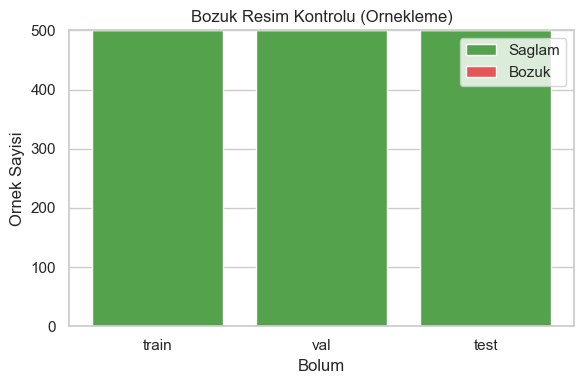

In [4]:
def count_bad_images(image_paths, max_samples=500):
    sample = sorted(image_paths)[:max_samples]
    bad = 0
    for path in sample:
        try:
            img = Image.open(path)
            img.verify()
        except Exception:
            bad += 1
    return {"ornek_sayisi": len(sample), "bozuk": bad, "saglam": len(sample) - bad}


rows = []
for split_name, paths in [("train", train_paths), ("val", val_paths), ("test", test_paths)]:
    stats = count_bad_images(paths, max_samples=500)
    rows.append({"bolum": split_name, **stats})

missing_df = pd.DataFrame(rows)

x = np.arange(len(missing_df))
plt.figure(figsize=(6, 4))
plt.bar(x, missing_df["saglam"], label="Saglam", color="#54A24B")
plt.bar(x, missing_df["bozuk"], bottom=missing_df["saglam"], label="Bozuk", color="#E45756")
plt.xticks(x, missing_df["bolum"])
plt.title("Bozuk Resim Kontrolu (Ornekleme)")
plt.xlabel("Bolum")
plt.ylabel("Ornek Sayisi")
plt.legend()
plt.tight_layout()
plt.show()


Ornekleme ile yapilan kontrolde bozuk dosya sayisi gozlemlenebilir. "Bozuk" sayisi sifir veya cok dusukse veri kalitesi iyi demektir. Eger yuksek cikarsa, ya veri kaynagi tekrar temizlenmeli ya da bozuk dosyalar listelenip egitimden cikartilmalidir; aksi halde model egitimi kesilebilir veya girdi kalitesi bozulabilir.


## 3. Ortam ve Tekrarlanabilirlik
Bu bolumde amacim, sonuclarin baska bir bilgisayarda bile ayni cikmasini saglamak. `src.utils_seed.set_seed`, `random.seed`, `numpy.random.seed` ve `sklearn.utils.check_random_state` ile tum rastgelelik kaynaklarini sabitliyorum. Ayrica `get_env_info` ile donanim ve kutuphane surumlerini yazdiriyorum; `torch`, `sklearn`, `matplotlib`, `seaborn` gibi kutuphanelerin surumleri kayda geciyor. Bu adimi veri hazirlamadan once yapiyorum cunku daha sonra olusan farklari takip etmek cok daha zor olur.

**Calistirma Adimlari**
```
1) Sanal ortam ve cekirdek secimi yap.
2) Hucreleri yukaridan asagi sirayla calistir.
3) Ciktilar `outputs/` altina kaydedilir.
```


In [5]:
import platform
import sklearn
import torch
import matplotlib
import seaborn
from sklearn.utils import check_random_state

from src.utils_seed import set_seed, get_env_info

set_seed(config.RANDOM_SEED)
random.seed(config.RANDOM_SEED)
np.random.seed(config.RANDOM_SEED)

sklearn_rng = check_random_state(config.RANDOM_SEED)

env_info = get_env_info()
env_info.update(
    {
        "numpy_version": np.__version__,
        "pandas_version": pd.__version__,
        "sklearn_version": sklearn.__version__,
        "matplotlib_version": matplotlib.__version__,
        "seaborn_version": seaborn.__version__,
    }
)

pd.DataFrame([env_info])


python_version                         os torch_version cuda_available  \
0         3.12.6  Windows-11-10.0.26200-SP0     2.9.1+cpu          False   

  numpy_version pandas_version sklearn_version matplotlib_version  \
0         2.2.6          2.3.3           1.8.0             3.10.8   

  seaborn_version  
0          0.13.2

## 4. Veri Hazirlama
Bu kisimda goruntuleri modele uygun hale getiriyorum. `torchvision.transforms.Compose` ile ard arda donusumler tanimliyorum: `Resize` ile boyutu sabitliyorum, `RandomHorizontalFlip` ve `ColorJitter` ile egitim icin veri arttirma yapiyorum, `ToTensor` ile PyTorch tensore ceviriyorum. `src.data.get_dataloaders` fonksiyonu ise bu donusumleri kullanarak train/val/test yukleyicilerini olusturuyor. Bu adim, modelden once gelmeli cunku model girdi boyutu ve formatina bagli.


In [6]:
from torchvision import transforms
from src.data import get_dataloaders

train_tfms = transforms.Compose(
    [
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
    ]
)

val_tfms = transforms.Compose(
    [
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
    ]
)

train_loader, val_loader, test_loader = get_dataloaders(
    processed_root,
    train_tfms,
    val_tfms,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS,
)

num_classes = len(train_loader.dataset.classes)
num_classes


24

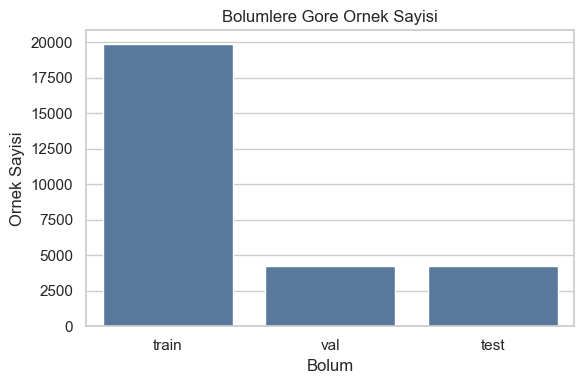

In [7]:
split_df = pd.DataFrame(
    {"bolum": list(split_sizes.keys()), "ornek_sayisi": list(split_sizes.values())}
)

plt.figure(figsize=(6, 4))
sns.barplot(data=split_df, x="bolum", y="ornek_sayisi", color="#4C78A8")
plt.title("Bolumlere Gore Ornek Sayisi")
plt.xlabel("Bolum")
plt.ylabel("Ornek Sayisi")
plt.tight_layout()
plt.show()


Bolum dagilimi dengeli ise modelin genelleme performansi daha saglikli okunur. Burada `seaborn.barplot` ile train/val/test ornek sayilarini goruyorum; barlar birbirine cok uzaksa veri bolmesinde sorun olabilir. Dengeli bir dagilim iyi bir isarettir; cok dengesizse val/test sonucu istikrarsiz olabilir ve metrikler yaniltici olur.


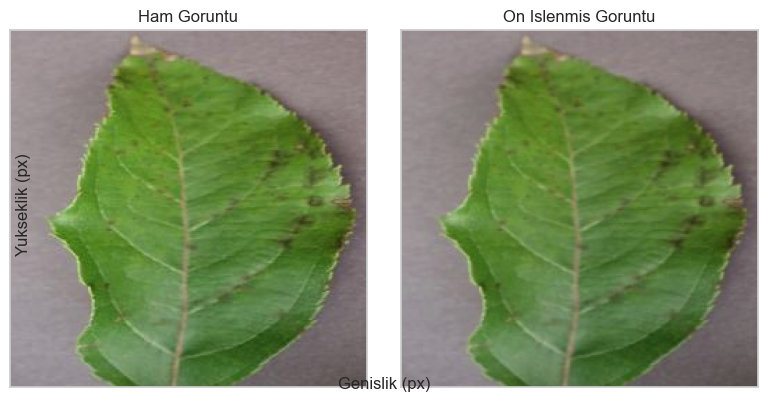

In [8]:
sample_path = train_paths[0]
orig_img = Image.open(sample_path).convert("RGB")
proc_img = train_tfms(orig_img)
proc_img_np = np.transpose(proc_img.numpy(), (1, 2, 0))
proc_img_np = np.clip(proc_img_np, 0, 1)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(orig_img)
axes[0].set_title("Ham Goruntu")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(proc_img_np)
axes[1].set_title("On Islenmis Goruntu")
axes[1].set_xticks([])
axes[1].set_yticks([])

fig.text(0.5, 0.04, "Genislik (px)", ha="center")
fig.text(0.04, 0.5, "Yukseklik (px)", va="center", rotation="vertical")
plt.tight_layout()
plt.show()


Ham ve on islenmis goruntu yan yana incelendiginde yeniden boyutlandirma ve normalize etmenin goruntu dinamiklerini nasil degistirdigi gorulur. Bu hucrede `PIL.Image.open` ile resmi okuyup, biraz once tanimladigim `train_tfms` ile donusturuyorum; `numpy.transpose` ile kanal sirasini duzeltiyorum ve `np.clip` ile gorsellestirmeyi 0-1 araliginda tutuyorum. Eger on islenmis goruntu tamamen karariyor ya da renkler cok bozuluyorsa bu kotu bir isarettir; dengeli ve net gorunuyorsa donusumler dogru demektir.


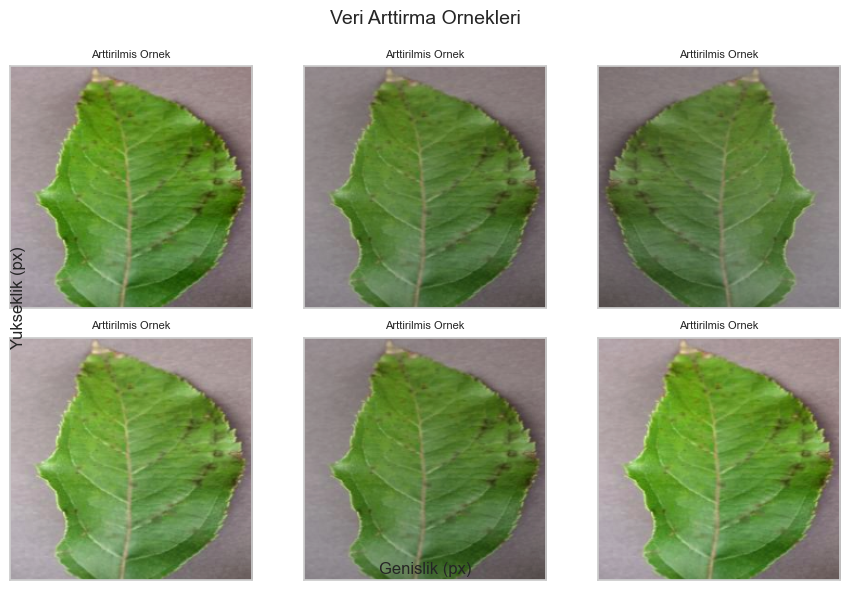

In [9]:
aug_examples = [train_tfms(orig_img) for _ in range(6)]

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for ax, img_t in zip(axes.ravel(), aug_examples):
    img_np = np.transpose(img_t.numpy(), (1, 2, 0))
    img_np = np.clip(img_np, 0, 1)
    ax.imshow(img_np)
    ax.set_title("Arttirilmis Ornek", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("Veri Arttirma Ornekleri", fontsize=14)
fig.text(0.5, 0.04, "Genislik (px)", ha="center")
fig.text(0.04, 0.5, "Yukseklik (px)", va="center", rotation="vertical")
plt.tight_layout()
plt.show()


Veri arttirma, yaprak goruntulerinde aydinlatma ve hizalama farklarina karsi dayanimi artirir. Burada ayni resmi `train_tfms` ile birden cok kez gecirip farkli varyasyonlar olusturuyorum ve `matplotlib` ile gosteriyorum. Orneklerde hafif donmeler, renk degisimleri ve ayna yansimalari gorulmesi beklenen (iyi) bir durumdur; eger goruntu tamamen bozuluyorsa veya yaprak yapisi kayboluyorsa arttirma parametreleri fazla agresif olabilir.


## 5. Temel Model (HOG + SVM)
Bu bolumde klasik bir temel yontem kuruyorum. `src.train.run_hog_svm_search` ile HOG parametreleri ve SVM C/agirlik seceneklerini kucuk bir arama ile deniyorum; bu sayede "en azindan" makul bir klasik model elde ediyorum. Ardindan `src.features.build_feature_matrix` HOG ozelliklerini cikartiyor, `encode_labels` ise sinif etiketlerini sayisal hale getiriyor. Degerlendirme icin `sklearn.metrics` tarafindan `precision_score`, `recall_score`, `f1_score`, `average_precision_score` kullaniyorum; PR AUC icin `sklearn.preprocessing.label_binarize` gerekli. Ek olarak `src.eval.classification_metrics`, `compute_confusion`, `compute_pr_curves`, `compute_micro_pr_curve` ile detayli metrikler ve PR egrileri hesapliyorum; `src.viz.plot_confusion_matrix` ve `plot_pr_curves` ise gorsellestirme sagliyor. Bu modeli derin ogrenmeden once kurmamim nedeni, karsilastirma icin hizli ve yorumlanabilir bir referans istemem.


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.preprocessing import label_binarize

from src.train import run_hog_svm_search
from src.features import build_feature_matrix, encode_labels
from src.eval import (
    classification_metrics,
    compute_confusion,
    compute_normalized_confusion,
    compute_pr_curves,
    compute_micro_pr_curve,
)
from src.viz import plot_confusion_matrix, plot_pr_curves

hog_grid = [
    {"orientations": 9, "pixels_per_cell": (8, 8), "cells_per_block": (2, 2), "block_norm": "L2-Hys"},
    {"orientations": 8, "pixels_per_cell": (16, 16), "cells_per_block": (2, 2), "block_norm": "L2-Hys"},
]

svm_param_grid = {
    "svm__C": [0.1, 1, 10],
    "svm__class_weight": [None, "balanced"],
}

svm_model, svm_config = run_hog_svm_search(
    train_paths,
    train_labels,
    config.CLASSICAL_IMAGE_SIZE,
    hog_grid,
    svm_param_grid,
    cv=3,
    search_n_iter=3,
)

X_test = build_feature_matrix(test_paths, config.CLASSICAL_IMAGE_SIZE, svm_config["hog_params"])
y_test, class_to_idx = encode_labels(test_labels)

y_pred = svm_model.predict(X_test)
y_score = svm_model.decision_function(X_test)

svm_metrics = classification_metrics(y_test, y_pred, target_names=sorted(class_to_idx.keys()))
macro_precision = precision_score(y_test, y_pred, average="macro")
macro_recall = recall_score(y_test, y_pred, average="macro")
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

class_names_sorted = sorted(class_to_idx.keys())
y_test_bin = label_binarize(y_test, classes=list(range(len(class_names_sorted))))
pr_auc_macro = average_precision_score(y_test_bin, y_score, average="macro")

cm_svm = compute_confusion(y_test, y_pred)
cm_svm_norm = compute_normalized_confusion(cm_svm)
pr_curves_svm = compute_pr_curves(y_test, y_score, num_classes=len(class_names_sorted))
micro_pr_svm = compute_micro_pr_curve(y_test, y_score, num_classes=len(class_names_sorted))

plot_confusion_matrix(cm_svm, class_names_sorted, config.FIGURES_DIR / "svm_confusion.png")
plot_confusion_matrix(cm_svm_norm, class_names_sorted, config.FIGURES_DIR / "svm_confusion_norm.png", normalize=True)
plot_pr_curves(pr_curves_svm, class_names_sorted, config.FIGURES_DIR / "svm_pr_curves.png", micro_curve=micro_pr_svm)

svm_results = {
    "model": "HOG+SVM",
    "accuracy": svm_metrics["accuracy"],
    "precision": macro_precision,
    "recall": macro_recall,
    "macro_f1": macro_f1,
    "weighted_f1": weighted_f1,
    "pr_auc_macro": pr_auc_macro,
}

svm_results


Loaded features from cache: D:\my_projects\Image Classification – Plant Leaf Disease Detection\project_leaf_disease\outputs\cache\hog_036b61fbaf60cafc0f7e90fc7cb5fa828bb94f3797971d918bcd2d72ad979512\features.npy
Searching on subset: 5000 of total 19862 samples
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .................svm__C=0.1, svm__class_weight=None; total time= 5.0min
[CV] END .................svm__C=0.1, svm__class_weight=None; total time= 4.5min
[CV] END .................svm__C=0.1, svm__class_weight=None; total time= 4.7min
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time= 4.7min
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time= 4.3min
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time= 4.8min
[CV] END ..............svm__C=10, svm__class_weight=balanced; total time= 4.9min
[CV] END ..............svm__C=10, svm__class_weight=balanced; total time= 4.5min
[CV] END ..............svm__C=10

Extracting features: 100%|██████████| 19862/19862 [01:03<00:00, 313.41it/s]


Saved features to cache: D:\my_projects\Image Classification – Plant Leaf Disease Detection\project_leaf_disease\outputs\cache\hog_1e2b4c735810312f67de226a709470f028bbe9131ed78e90eb8329642ecb37f5\features.npy
Searching on subset: 5000 of total 19862 samples
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .................svm__C=0.1, svm__class_weight=None; total time= 3.0min
[CV] END .................svm__C=0.1, svm__class_weight=None; total time= 2.8min
[CV] END .................svm__C=0.1, svm__class_weight=None; total time= 3.1min
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time= 2.9min
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time= 2.9min
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time= 2.9min


d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\sklearn\svm\_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..............svm__C=10, svm__class_weight=balanced; total time=22.1min


d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\sklearn\svm\_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..............svm__C=10, svm__class_weight=balanced; total time=21.8min


d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\sklearn\svm\_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..............svm__C=10, svm__class_weight=balanced; total time=21.7min
Refitting best model on full dataset: 19862 samples


Extracting features: 100%|██████████| 4257/4257 [00:13<00:00, 309.20it/s]


Saved features to cache: D:\my_projects\Image Classification – Plant Leaf Disease Detection\project_leaf_disease\outputs\cache\hog_61709489965a2e2a54dcd1a973dce80b111143399162972a1f7259f8df5195ca\features.npy


{'model': 'HOG+SVM',
 'accuracy': 0.8522433638712709,
 'precision': 0.7935872950443517,
 'recall': 0.7863647425472621,
 'macro_f1': 0.7887182205923056,
 'weighted_f1': 0.8501001443112618,
 'pr_auc_macro': 0.7974370766029361}

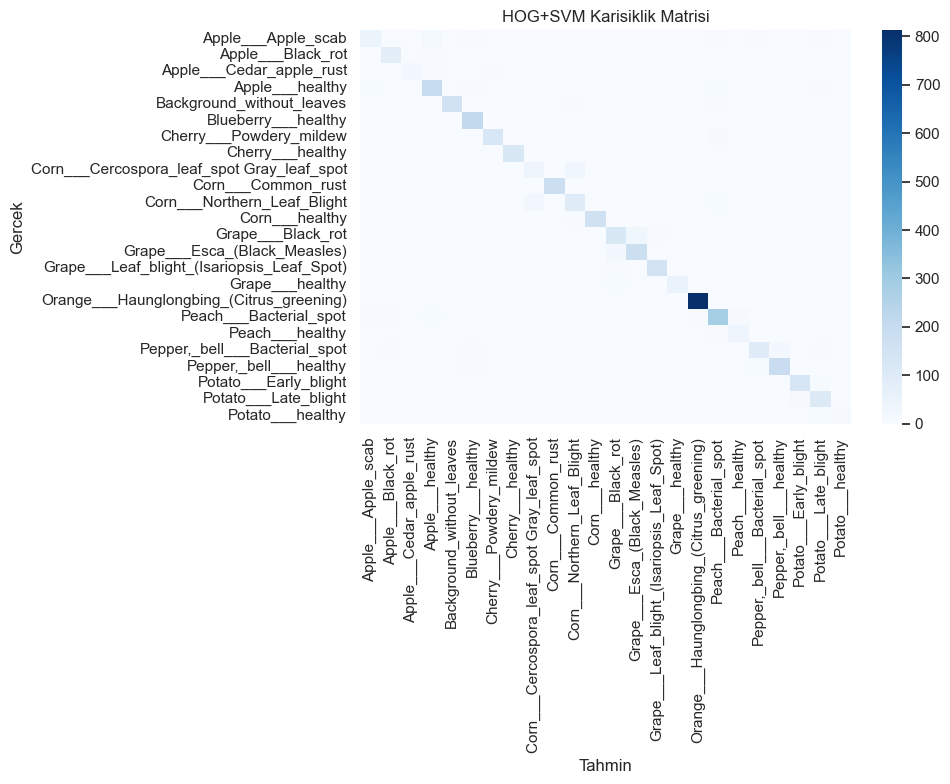

In [11]:
cm_df = pd.DataFrame(cm_svm, index=class_names_sorted, columns=class_names_sorted)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, cmap="Blues")
plt.title("HOG+SVM Karisiklik Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gercek")
plt.tight_layout()
plt.show()


Karisiklik matrisi, temel modelin hangi siniflari karistirdigini acikca gosterir. Bu hucrede `pandas.DataFrame` ile matrisi tabloya cevirip `seaborn.heatmap` ile isik/renk yogunlugunu goruyorum (ilk kez burada detayini anlatiyorum). Diyagonal boyunca koyu renkler iyi bir isarettir; diyagonalin disinda buyuk bloklar varsa model benzer siniflari ayiramiyor demektir. Bu bilgi, hangi siniflara daha cok veri veya ayirt edici ozellik gerektigini gosterir.


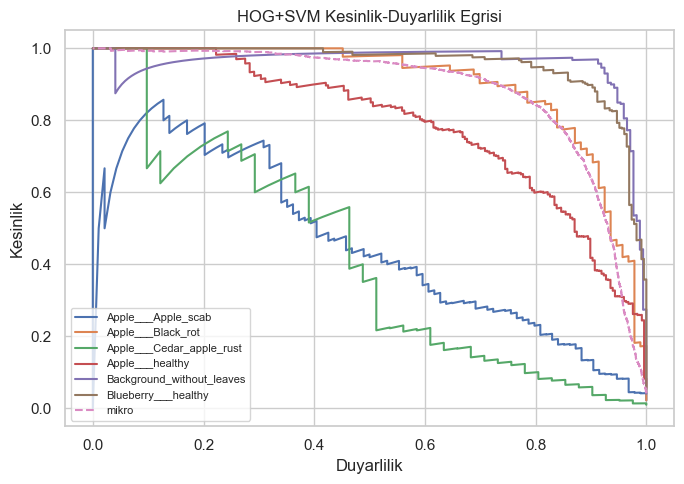

In [12]:
plt.figure(figsize=(7, 5))
for idx, curve in pr_curves_svm.items():
    if idx >= 6:
        break
    plt.plot(curve["recall"], curve["precision"], label=class_names_sorted[idx])
plt.plot(micro_pr_svm["recall"], micro_pr_svm["precision"], label="mikro", linestyle="--")
plt.title("HOG+SVM Kesinlik-Duyarlilik Egrisi")
plt.xlabel("Duyarlilik")
plt.ylabel("Kesinlik")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


Kesinlik-Duyarlilik egrileri, sinif bazinda modelin duyarlilik ve kesinlik dengesini ortaya koyar. Bu hucrede daha once hesaplanan PR noktalarini `matplotlib` ile ciziyorum (cizim fonksiyonlarini daha once anlattim). Egrilerin yukari-sag koseye yakin olmasi iyi; egri asagiya dusuyorsa model o sinifta guvenilir degil demektir. Az ornekli siniflarda egri daha dalgali gorunebilir, bu dengeli olmayan veri icin beklenen bir durumdur.


C:\Users\pc\AppData\Local\Temp\ipykernel_14672\127802174.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


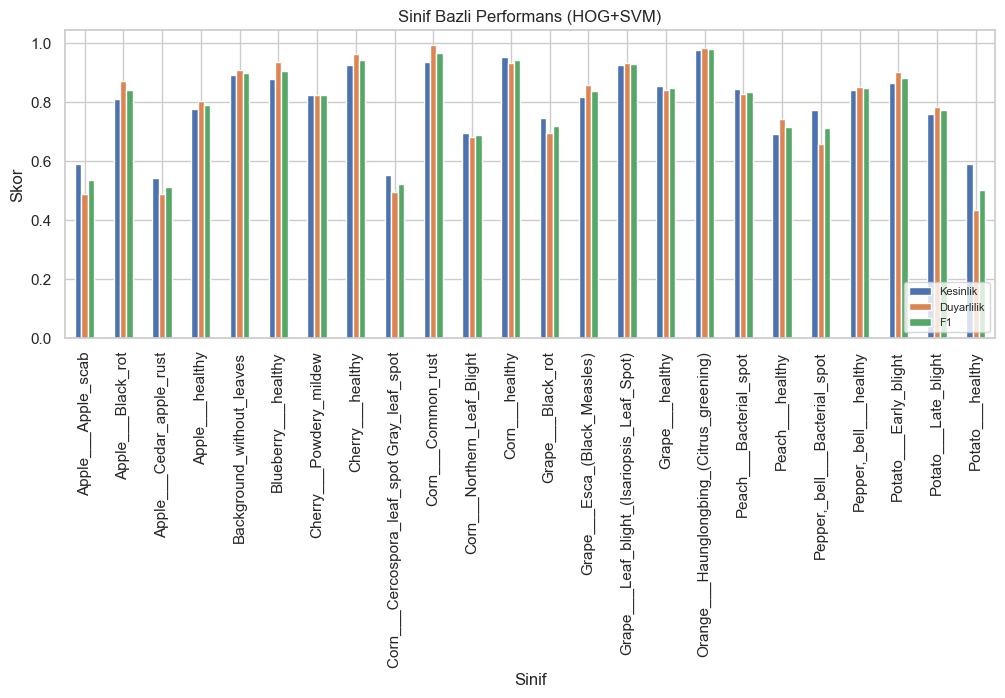

In [13]:
svm_report_df = pd.DataFrame(svm_metrics["report"]).T
class_report = svm_report_df.loc[class_names_sorted, ["precision", "recall", "f1-score"]]
class_report = class_report.rename(columns={"precision": "Kesinlik", "recall": "Duyarlilik", "f1-score": "F1"})

plt.figure(figsize=(12, 4))
class_report.plot(kind="bar", ax=plt.gca())
plt.title("Sinif Bazli Performans (HOG+SVM)")
plt.xlabel("Sinif")
plt.ylabel("Skor")
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()


Sinif bazli bar grafik, hangi siniflarda precision veya recall kaybi oldugunu gosterir. `pandas.DataFrame.plot(kind="bar")` ile tabloyu grafige ceviriyorum; bu fonksiyon sayesinde siniflar arasi karsilastirma daha net oluyor. Barlar arasinda buyuk fark varsa o sinifta ya veri azdir ya da goruntu benzerligi yuksektir; dengeli barlar ise modelin daha tutarli calistigini gosterir.


## 6. Gelismis / Karsilastirmali Model (Transfer Ogrenme - ResNet-18)
Bu kisimda PyTorch ile ResNet-18 transfer ogrenme uyguluyorum. `src.models.build_resnet18` hazir bir agirlikli modeli getiriyor; `torch.nn.CrossEntropyLoss` siniflandirma kaybini veriyor. Optimizasyon icin `get_optimizer`, ogrenme oranini zamanla azaltmak icin `get_scheduler` kullaniyorum. Egitim dongusu `src.train.train_model` fonksiyonunda; tahmin ve olasilik ciktilari icin `src.eval.predict_torch` var. Ilk asamada govdeyi dondurup sadece son katmanlari egitiyorum, sonra ince ayara geciyorum; bu siralama, az veriyle overfitting riskini azaltip daha kontrollu iyilestirme sagliyor.


In [14]:
import torch

from src.models import build_resnet18, get_optimizer, get_scheduler
from src.train import train_model
from src.eval import predict_torch
from src.viz import save_misclassifications, save_gradcam_examples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = build_resnet18(num_classes=num_classes, pretrained=True, freeze_backbone=True).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = get_optimizer(model, lr=config.DEFAULT_LR, weight_decay=config.DEFAULT_WEIGHT_DECAY)
scheduler = get_scheduler(optimizer, scheduler_name="step")

model, history = train_model(
    model,
    {"train": train_loader, "val": val_loader},
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=config.DEFAULT_NUM_EPOCHS,
    early_stopping_patience=config.EARLY_STOPPING_PATIENCE,
    checkpoint_path=str(config.MODELS_DIR / "resnet18_baseline.pt"),
)

y_true, y_pred, y_proba = predict_torch(model, test_loader, device)

metrics_dl = classification_metrics(y_true, y_pred, target_names=class_names)
macro_precision_dl = precision_score(y_true, y_pred, average="macro")
macro_recall_dl = recall_score(y_true, y_pred, average="macro")
macro_f1_dl = f1_score(y_true, y_pred, average="macro")
weighted_f1_dl = f1_score(y_true, y_pred, average="weighted")

y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
pr_auc_macro_dl = average_precision_score(y_true_bin, y_proba, average="macro")

cm_dl = compute_confusion(y_true, y_pred)
cm_dl_norm = compute_normalized_confusion(cm_dl)
pr_curves_dl = compute_pr_curves(y_true, y_proba, num_classes=len(class_names))
micro_pr_dl = compute_micro_pr_curve(y_true, y_proba, num_classes=len(class_names))

plot_confusion_matrix(cm_dl, class_names, config.FIGURES_DIR / "resnet18_confusion.png")
plot_confusion_matrix(cm_dl_norm, class_names, config.FIGURES_DIR / "resnet18_confusion_norm.png", normalize=True)
plot_pr_curves(pr_curves_dl, class_names, config.FIGURES_DIR / "resnet18_pr_curves.png", micro_curve=micro_pr_dl)

save_misclassifications(test_loader.dataset.samples, y_true, y_pred, class_names, config.FIGURES_DIR / "resnet18_misclassified.png")


dl_results = {
    "model": "ResNet18 Transfer (Dondurulmus)",
    "accuracy": metrics_dl["accuracy"],
    "precision": macro_precision_dl,
    "recall": macro_recall_dl,
    "macro_f1": macro_f1_dl,
    "weighted_f1": weighted_f1_dl,
    "pr_auc_macro": pr_auc_macro_dl,
}

dl_results


d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but 

{'model': 'ResNet18 Transfer (Dondurulmus)',
 'accuracy': 0.982851773549448,
 'precision': 0.9716330214934962,
 'recall': 0.9727220345503848,
 'macro_f1': 0.9721171883581334,
 'weighted_f1': 0.9827625388049891,
 'pr_auc_macro': 0.9905678373501479}

In [15]:
train_tfms_ft = transforms.Compose(
    [
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.RandomResizedCrop(config.IMG_SIZE, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.ToTensor(),
    ]
)

train_loader_ft, val_loader_ft, test_loader_ft = get_dataloaders(
    processed_root,
    train_tfms_ft,
    val_tfms,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS,
)

model_ft = build_resnet18(num_classes=num_classes, pretrained=True, freeze_backbone=False).to(device)
optimizer_ft = get_optimizer(model_ft, lr=3e-4, weight_decay=1e-5)
scheduler_ft = get_scheduler(optimizer_ft, scheduler_name="step")

model_ft, history_ft = train_model(
    model_ft,
    {"train": train_loader_ft, "val": val_loader_ft},
    criterion,
    optimizer_ft,
    scheduler_ft,
    device,
    num_epochs=config.DEFAULT_NUM_EPOCHS,
    early_stopping_patience=config.EARLY_STOPPING_PATIENCE,
    checkpoint_path=str(config.MODELS_DIR / "resnet18_finetune.pt"),
)

y_true_ft, y_pred_ft, y_proba_ft = predict_torch(model_ft, test_loader_ft, device)

metrics_ft = classification_metrics(y_true_ft, y_pred_ft, target_names=class_names)
macro_precision_ft = precision_score(y_true_ft, y_pred_ft, average="macro")
macro_recall_ft = recall_score(y_true_ft, y_pred_ft, average="macro")
macro_f1_ft = f1_score(y_true_ft, y_pred_ft, average="macro")
weighted_f1_ft = f1_score(y_true_ft, y_pred_ft, average="weighted")

y_true_ft_bin = label_binarize(y_true_ft, classes=list(range(len(class_names))))
pr_auc_macro_ft = average_precision_score(y_true_ft_bin, y_proba_ft, average="macro")

cm_ft = compute_confusion(y_true_ft, y_pred_ft)
cm_ft_norm = compute_normalized_confusion(cm_ft)
pr_curves_ft = compute_pr_curves(y_true_ft, y_proba_ft, num_classes=len(class_names))
micro_pr_ft = compute_micro_pr_curve(y_true_ft, y_proba_ft, num_classes=len(class_names))

plot_confusion_matrix(cm_ft, class_names, config.FIGURES_DIR / "resnet18_finetune_confusion.png")
plot_confusion_matrix(cm_ft_norm, class_names, config.FIGURES_DIR / "resnet18_finetune_confusion_norm.png", normalize=True)
plot_pr_curves(pr_curves_ft, class_names, config.FIGURES_DIR / "resnet18_finetune_pr_curves.png", micro_curve=micro_pr_ft)

save_misclassifications(test_loader_ft.dataset.samples, y_true_ft, y_pred_ft, class_names, config.FIGURES_DIR / "resnet18_finetune_misclassified.png")

dl_ft_results = {
    "model": "ResNet18 Transfer (Ince Ayar)",
    "accuracy": metrics_ft["accuracy"],
    "precision": macro_precision_ft,
    "recall": macro_recall_ft,
    "macro_f1": macro_f1_ft,
    "weighted_f1": weighted_f1_ft,
    "pr_auc_macro": pr_auc_macro_ft,
}

dl_ft_results


d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but 

{'model': 'ResNet18 Transfer (Ince Ayar)',
 'accuracy': 0.9957716701902748,
 'precision': 0.9889210865238263,
 'recall': 0.9930321722225489,
 'macro_f1': 0.9908247087582307,
 'weighted_f1': 0.9957964701853297,
 'pr_auc_macro': 0.9977081065841285}

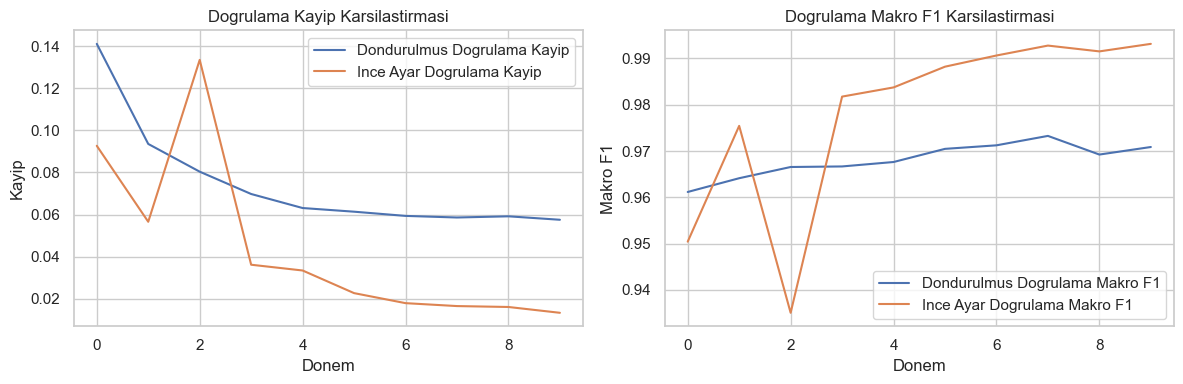

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history["val_loss"], label="Dondurulmus Dogrulama Kayip")
axes[0].plot(history_ft["val_loss"], label="Ince Ayar Dogrulama Kayip")
axes[0].set_title("Dogrulama Kayip Karsilastirmasi")
axes[0].set_xlabel("Donem")
axes[0].set_ylabel("Kayip")
axes[0].legend()

axes[1].plot(history["val_macro_f1"], label="Dondurulmus Dogrulama Makro F1")
axes[1].plot(history_ft["val_macro_f1"], label="Ince Ayar Dogrulama Makro F1")
axes[1].set_title("Dogrulama Makro F1 Karsilastirmasi")
axes[1].set_xlabel("Donem")
axes[1].set_ylabel("Makro F1")
axes[1].legend()

plt.tight_layout()
plt.show()


Egitim egrileri, ince ayar yaklasiminin val kayip ve val F1 uzerindeki etkisini gosterir. Burada `matplotlib` ile iki modelin dogrulama kayip ve makro F1 egirilerini yan yana karsilastiriyorum. Ince ayar egri olarak daha dusuk kayip ve daha yuksek F1 veriyorsa bu iyi bir isaret; eger F1 artmiyor ama kayip dalgalaniyorsa, modelin gereksiz yere zorlandigi veya overfitting oldugu dusunulebilir.


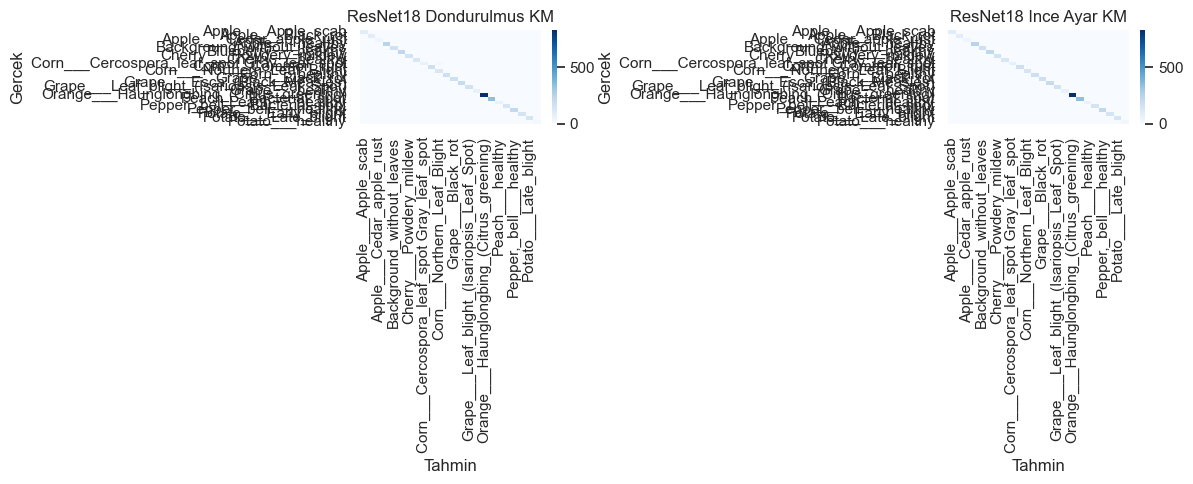

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_dl_df = pd.DataFrame(cm_dl, index=class_names, columns=class_names)
cm_ft_df = pd.DataFrame(cm_ft, index=class_names, columns=class_names)

sns.heatmap(cm_dl_df, cmap="Blues", ax=axes[0])
axes[0].set_title("ResNet18 Dondurulmus KM")
axes[0].set_xlabel("Tahmin")
axes[0].set_ylabel("Gercek")

sns.heatmap(cm_ft_df, cmap="Blues", ax=axes[1])
axes[1].set_title("ResNet18 Ince Ayar KM")
axes[1].set_xlabel("Tahmin")
axes[1].set_ylabel("Gercek")

plt.tight_layout()
plt.show()


Karisiklik matrisleri karsilastirildiginda fine-tune modelinin daha az sinif karisikligi urettigi beklenir. Burada yine `seaborn.heatmap` kullaniyorum (fonksiyonun mantigini onceki matris hucrelerinde anlattim) ve iki matrisi yan yana goruyorum. Ince ayar matrisinde diyagonal daha belirginse bu gelisme demektir; eger hala ayni sinif ciftlerinde yogun hata varsa veri/ozellik problemi suruyor olabilir.


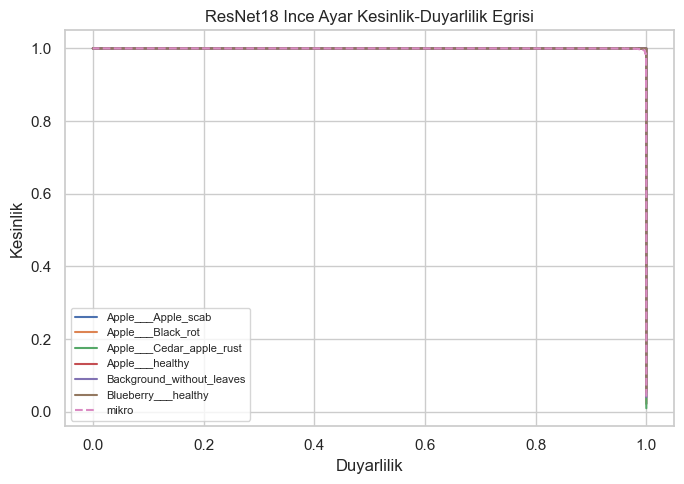

In [18]:
plt.figure(figsize=(7, 5))
for idx, curve in pr_curves_ft.items():
    if idx >= 6:
        break
    plt.plot(curve["recall"], curve["precision"], label=class_names[idx])
plt.plot(micro_pr_ft["recall"], micro_pr_ft["precision"], label="mikro", linestyle="--")
plt.title("ResNet18 Ince Ayar Kesinlik-Duyarlilik Egrisi")
plt.xlabel("Duyarlilik")
plt.ylabel("Kesinlik")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


Ince Ayar modelinin PR egrileri, siniflar arasindaki performans dalgalanmasini gostermekte ve zor siniflari tespit etmeye yardimci olmaktadir. `matplotlib` ile yine sinif bazli egrileri ciziyorum. Egriler baslangicta yuksekse model guvenilir; mikro ortalama egrisi digerlerinden cok ayrisiyorsa siniflar arasi dengesizlik etkisi suruyor demektir.


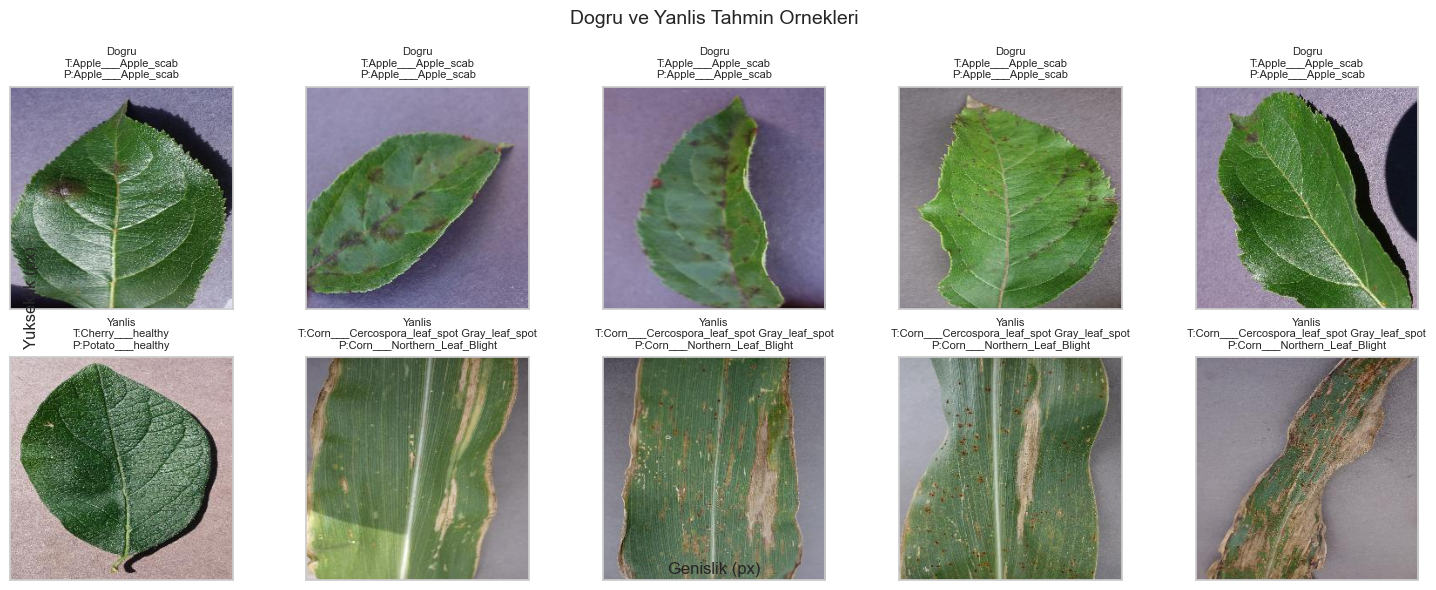

In [19]:
def plot_correct_incorrect_grid(samples, y_true_arr, y_pred_arr, class_names, n_cols=5):
    correct_idx = np.where(y_true_arr == y_pred_arr)[0]
    incorrect_idx = np.where(y_true_arr != y_pred_arr)[0]
    n = min(n_cols, len(correct_idx), len(incorrect_idx))
    fig, axes = plt.subplots(2, n, figsize=(n * 3, 6))
    for i in range(n):
        idx = correct_idx[i]
        img_path, _ = samples[idx]
        img = Image.open(img_path).convert("RGB")
        axes[0, i].imshow(img)
        axes[0, i].set_title(
            f"Dogru\nT:{class_names[y_true_arr[idx]]}\nP:{class_names[y_pred_arr[idx]]}",
            fontsize=8,
        )
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        idx = incorrect_idx[i]
        img_path, _ = samples[idx]
        img = Image.open(img_path).convert("RGB")
        axes[1, i].imshow(img)
        axes[1, i].set_title(
            f"Yanlis\nT:{class_names[y_true_arr[idx]]}\nP:{class_names[y_pred_arr[idx]]}",
            fontsize=8,
        )
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

    fig.suptitle("Dogru ve Yanlis Tahmin Ornekleri", fontsize=14)
    fig.text(0.5, 0.04, "Genislik (px)", ha="center")
    fig.text(0.04, 0.5, "Yukseklik (px)", va="center", rotation="vertical")
    plt.tight_layout()
    plt.show()


plot_correct_incorrect_grid(test_loader_ft.dataset.samples, y_true_ft, y_pred_ft, class_names)


Dogru ve yanlis tahminlerin yan yana gorulmesi, modelin hangi goruntu kosullarinda guclu veya zayif oldugunu gorsel olarak ortaya koyar. `plot_correct_incorrect_grid` fonksiyonu icinde `numpy.where` ile dogru/yanlis indeksleri ayriliyor, `PIL.Image.open` ile goruntu okunuyor ve `matplotlib` ile grid halinde gosteriliyor. Dogru orneklerde yaprak belirgin ise bu iyi; yanlis orneklerde arka plan baskinsa veya hastalik izi belirsizse modelin zorlanmasi normaldir.


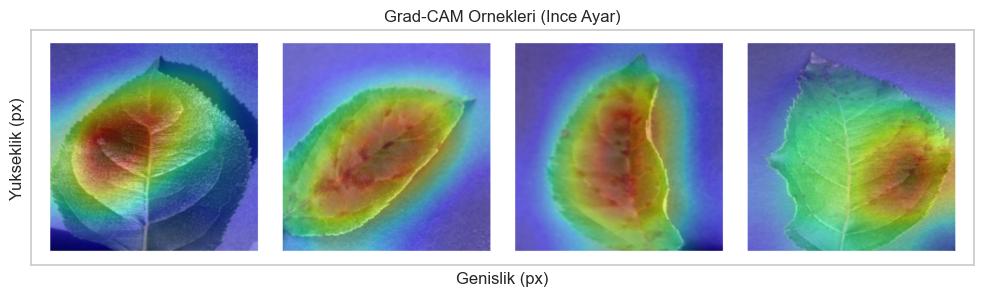

In [20]:
gradcam_path = config.FIGURES_DIR / "resnet18_gradcam.png"
save_gradcam_examples(model_ft, test_loader_ft.dataset, device, gradcam_path, model_ft.layer4)

img = Image.open(gradcam_path)
plt.figure(figsize=(10, 3))
plt.imshow(img)
plt.title("Grad-CAM Ornekleri (Ince Ayar)")
plt.xlabel("Genislik (px)")
plt.ylabel("Yukseklik (px)")
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()


Grad-CAM gorselleri, modelin karar verirken odaklandigi bolgeleri gosterir. `src.viz.save_gradcam_examples` fonksiyonu (PyTorch tabanli) ile ResNet-18'in `layer4` katmani uzerinden aciklayici haritalar cikartiyorum. Eger isiklanan bolge yapraktaki leke/doku ustundeyse bu iyi bir isarettir; arka plan veya kenarlara odaklaniyorsa model yanlis ipuclari ogreniyor olabilir.


## 7. Sayisal Yontem / Optimizasyon Katkisi
Bu bolumde ogrenme orani ve weight decay icin kisa bir tarama yaparak sayisal bir karsilastirma yapacagim. `src.train.run_lr_sweep` fonksiyonu, farkli ayarlarla ayni modeli kisa sureli egitip en iyi dogrulama makro F1 degerini topluyor. Bu adimi temel ve ince ayar modellerini kurduktan sonra yapiyorum cunku once bir referans performansim olmali; sonra ayarlarin gercekten iyilesme getirip getirmedigini gorebilirim.


In [21]:
from src.train import run_lr_sweep


def make_optimizer(lr, weight_decay):
    return lambda model: get_optimizer(model, lr=lr, weight_decay=weight_decay)


search_space = [
    {
        "label": "lr=1e-3 wd=1e-4",
        "lr": 1e-3,
        "weight_decay": 1e-4,
        "model_kwargs": {"num_classes": num_classes, "pretrained": True, "freeze_backbone": True},
        "optimizer_fn": make_optimizer(1e-3, 1e-4),
        "scheduler_fn": lambda opt: get_scheduler(opt, scheduler_name="step"),
    },
    {
        "label": "lr=3e-4 wd=1e-5",
        "lr": 3e-4,
        "weight_decay": 1e-5,
        "model_kwargs": {"num_classes": num_classes, "pretrained": True, "freeze_backbone": True},
        "optimizer_fn": make_optimizer(3e-4, 1e-5),
        "scheduler_fn": lambda opt: get_scheduler(opt, scheduler_name="step"),
    },
    {
        "label": "lr=1e-4 wd=1e-4",
        "lr": 1e-4,
        "weight_decay": 1e-4,
        "model_kwargs": {"num_classes": num_classes, "pretrained": True, "freeze_backbone": True},
        "optimizer_fn": make_optimizer(1e-4, 1e-4),
        "scheduler_fn": lambda opt: get_scheduler(opt, scheduler_name="step"),
    },
]

sweep_results = run_lr_sweep(
    lambda **kwargs: build_resnet18(**kwargs),
    {"train": train_loader, "val": val_loader},
    criterion,
    device,
    search_space,
    num_epochs=5,
    checkpoint_dir=str(config.MODELS_DIR),
    early_stopping_patience=3,
)

sweep_df = pd.DataFrame(
    [
        {
            "label": res["config"]["label"],
            "lr": res["config"]["lr"],
            "weight_decay": res["config"]["weight_decay"],
            "best_val_macro_f1": res["best_val_macro_f1"],
        }
        for res in sweep_results
    ]
)

sweep_df


d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\my_projects\Image Classification – Plant Leaf Disease Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but 

label      lr  weight_decay  best_val_macro_f1
0  lr=1e-3 wd=1e-4  0.0010       0.00010           0.970288
1  lr=3e-4 wd=1e-5  0.0003       0.00001           0.966550
2  lr=1e-4 wd=1e-4  0.0001       0.00010           0.946643

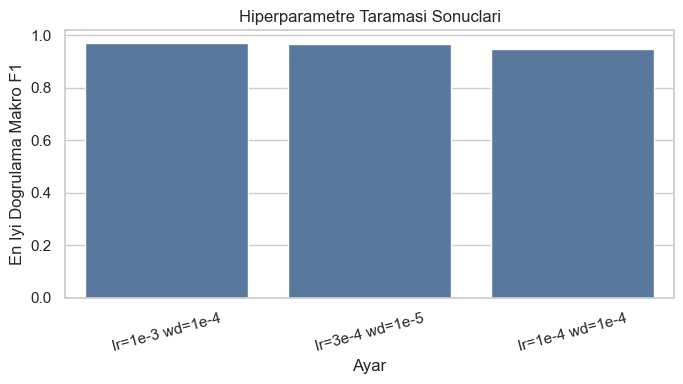

In [22]:
plt.figure(figsize=(7, 4))
sns.barplot(data=sweep_df, x="label", y="best_val_macro_f1", color="#4C78A8")
plt.title("Hiperparametre Taramasi Sonuclari")
plt.xlabel("Ayar")
plt.ylabel("En Iyi Dogrulama Makro F1")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


Hiperparametre sonuclari, ogrenme orani ve weight decay farklarinin val F1 uzerindeki etkisini gosterir. `seaborn.barplot` ile ayarlarin karsilastirmasi net gorunuyor. En yuksek bar, o ayarin daha iyi bir denge kurdugunu gosterir; barlar birbirine cok yakin ise hiperparametrelerin etkisi sinirli olabilir ve daha genis bir arama gerekebilir.


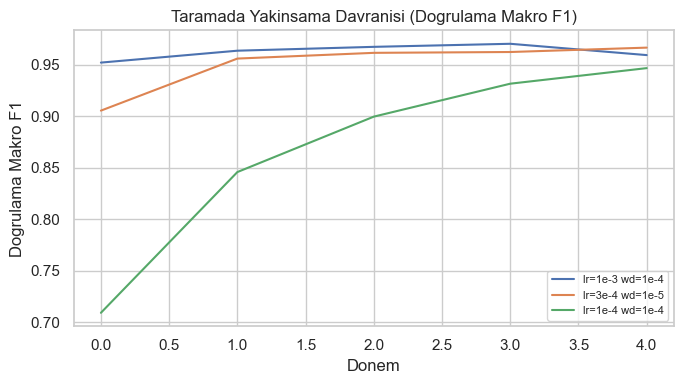

In [23]:
plt.figure(figsize=(7, 4))
for res in sweep_results:
    label = res["config"]["label"]
    history_sweep = res["history"]
    plt.plot(history_sweep["val_macro_f1"], label=label)

plt.title("Taramada Yakinsama Davranisi (Dogrulama Makro F1)")
plt.xlabel("Donem")
plt.ylabel("Dogrulama Makro F1")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


Yakinsama grafigi, farkli ayarlarin ogrenme hizini ve stabilitesini ortaya koyar. `matplotlib` ile epoch boyunca val F1 degisimlerini ciziyorum. Duzgun ve istikrarlı artan bir egri iyi; zikzakli veya surekli dusen egri ise o ayarin kararsiz oldugunu ve genelleme riski tasidigini gosterir.


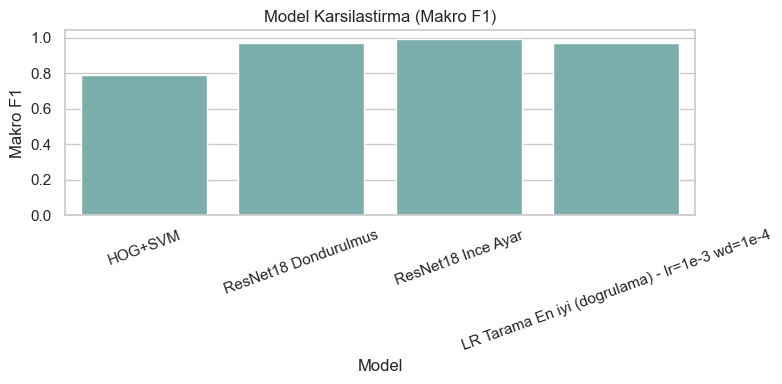

In [24]:
best_sweep = max(sweep_results, key=lambda r: r["best_val_macro_f1"]) if sweep_results else None
best_val_macro_f1 = best_sweep["best_val_macro_f1"] if best_sweep else None
best_label = best_sweep["config"]["label"] if best_sweep else "n/a"

comparison_df = pd.DataFrame(
    [
        {"model": "HOG+SVM", "macro_f1": svm_results["macro_f1"], "accuracy": svm_results["accuracy"]},
        {"model": "ResNet18 Dondurulmus", "macro_f1": dl_results["macro_f1"], "accuracy": dl_results["accuracy"]},
        {"model": "ResNet18 Ince Ayar", "macro_f1": dl_ft_results["macro_f1"], "accuracy": dl_ft_results["accuracy"]},
        {"model": f"LR Tarama En iyi (dogrulama) - {best_label}", "macro_f1": best_val_macro_f1, "accuracy": np.nan},
    ]
)

plt.figure(figsize=(8, 4))
sns.barplot(data=comparison_df, x="model", y="macro_f1", color="#72B7B2")
plt.title("Model Karsilastirma (Makro F1)")
plt.xlabel("Model")
plt.ylabel("Makro F1")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


Karsilastirma grafigi, temel ve gelismis yaklasimlarin performansini tek bakista gosterir. `pandas` ile olusturdugum karsilastirma tablosunu `seaborn` ile bar grafige ceviriyorum. Burada tarama sonucu dogrulama tabanli oldugu icin test metrikleriyle birebir ayni olmayabilir; bu yuzden barlar arasindaki farki yorumlarken bu ayrimi aklimda tutuyorum.


## 8. Degerlendirme ve Sonuclar
Bu bolumde tum modellerin metriklerini bir tabloya toparlayip karsilastiriyorum. `results_df` tablosu sayesinde accuracy, macro F1 gibi degerleri yan yana gorebiliyorum; ardindan grafiklerle yorumlamak daha kolay oluyor. Buraya kadar olan tum adimlarin amaci, "hangi model daha iyi?" sorusunu sayisal olarak netlestirmekti.


In [25]:
tuned_results = {
    "model": f"ResNet18 Tarama En iyi (dogrulama) - {best_label}",
    "accuracy": np.nan,
    "precision": np.nan,
    "recall": np.nan,
    "macro_f1": best_val_macro_f1,
    "weighted_f1": np.nan,
    "pr_auc_macro": np.nan,
}

results_df = pd.DataFrame([svm_results, dl_results, dl_ft_results, tuned_results])
results_df


model  accuracy  precision  \
0                                            HOG+SVM  0.852243   0.793587   
1                    ResNet18 Transfer (Dondurulmus)  0.982852   0.971633   
2                      ResNet18 Transfer (Ince Ayar)  0.995772   0.988921   
3  ResNet18 Tarama En iyi (dogrulama) - lr=1e-3 w...       NaN        NaN   

     recall  macro_f1  weighted_f1  pr_auc_macro  
0  0.786365  0.788718     0.850100      0.797437  
1  0.972722  0.972117     0.982763      0.990568  
2  0.993032  0.990825     0.995796      0.997708  
3       NaN  0.970288          NaN           NaN

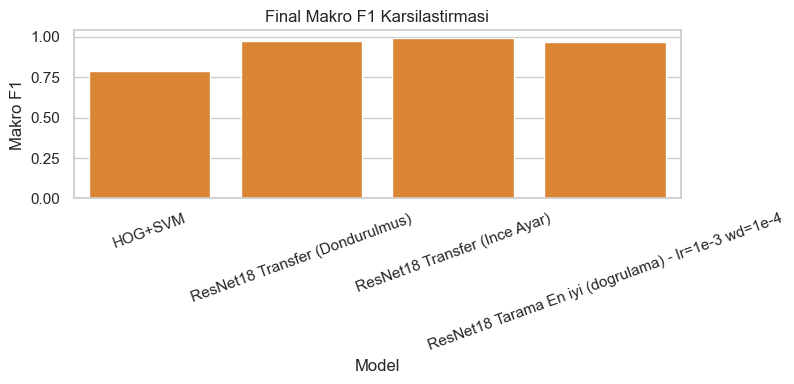

In [26]:
plt.figure(figsize=(8, 4))
plot_df = results_df.dropna(subset=["macro_f1"])
sns.barplot(data=plot_df, x="model", y="macro_f1", color="#F58518")
plt.title("Final Makro F1 Karsilastirmasi")
plt.xlabel("Model")
plt.ylabel("Makro F1")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


Tablo ve bar grafik birlikte incelendiginde, hangi modelin daha yuksek makro F1 urettigi net olarak gorulur. `seaborn.barplot` ile yaptigim son grafik, siniflar arasi dengeli performansi vurguluyor. Eger makro F1 bariz yuksekse bu iyi; ama sadece accuracy artip makro F1 dusukse, modelin az ornekli siniflari ihmal ettigi anlamina gelebilir.


C:\Users\pc\AppData\Local\Temp\ipykernel_14672\1634388669.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


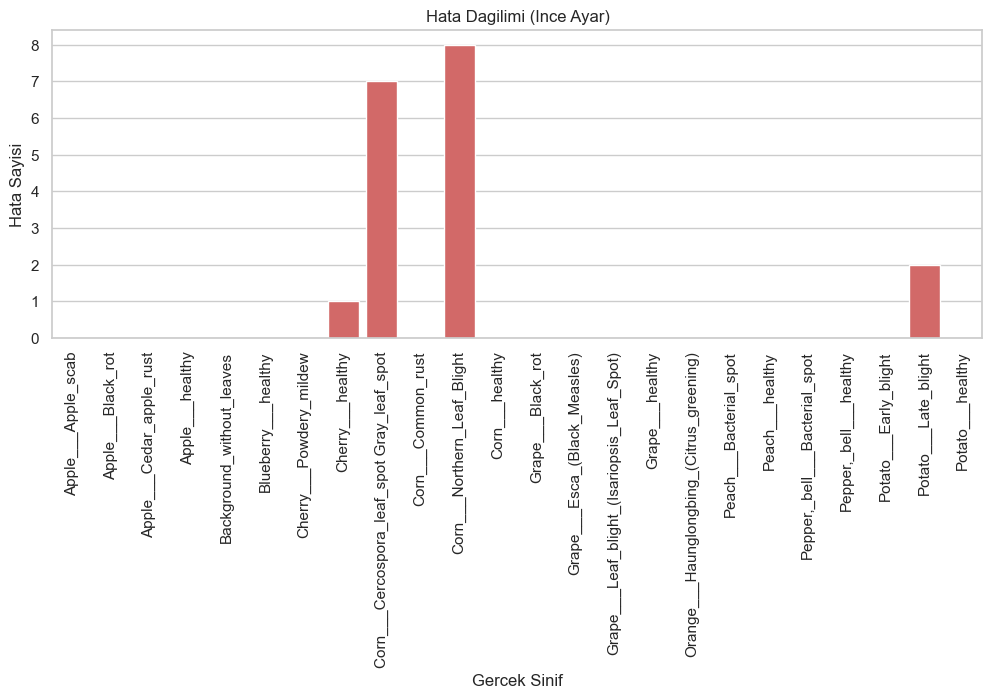

In [27]:
mis_mask = y_true_ft != y_pred_ft
err_counts = (
    pd.Series(y_true_ft[mis_mask])
    .value_counts()
    .reindex(range(len(class_names)), fill_value=0)
)

plt.figure(figsize=(12, 4))
sns.barplot(x=class_names, y=err_counts.values, color="#E45756")
plt.title("Hata Dagilimi (Ince Ayar)")
plt.xlabel("Gercek Sinif")
plt.ylabel("Hata Sayisi")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Hata dagilimi, modelin hangi siniflarda daha fazla yanildigini gosterir. Burada `pandas.Series.value_counts` ve `seaborn.barplot` ile hatalari sinif bazinda sayiyorum. Bazi siniflarda hata cok yuksekse bu siniflarin goruntu kalitesi dusuk olabilir ya da siniflar birbirine cok benziyordur; dengeli bir hata dagilimi ise modelin tutarli oldugunu gosterir.


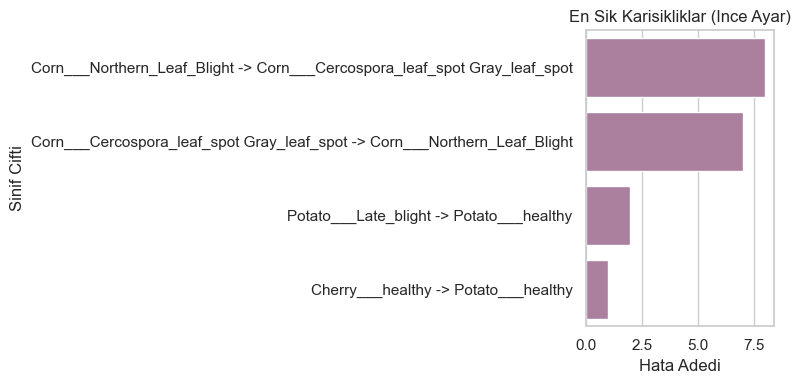

In [28]:
off_diag = cm_ft.copy()
np.fill_diagonal(off_diag, 0)

pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if off_diag[i, j] > 0:
            pairs.append(
                {
                    "gercek": class_names[i],
                    "tahmin": class_names[j],
                    "adet": off_diag[i, j],
                }
            )

pairs_df = pd.DataFrame(pairs).sort_values("adet", ascending=False).head(10)
pairs_df["pair"] = pairs_df["gercek"] + " -> " + pairs_df["tahmin"]

plt.figure(figsize=(8, 4))
sns.barplot(data=pairs_df, x="adet", y="pair", color="#B279A2")
plt.title("En Sik Karisikliklar (Ince Ayar)")
plt.xlabel("Hata Adedi")
plt.ylabel("Sinif Cifti")
plt.tight_layout()
plt.show()


En sik karisikliklar, belirli sinif ciftlerinin gorunsel olarak cok benzer oldugunu isaret eder. `numpy.fill_diagonal` ile dogru tahminleri sifirlayip yalnizca hatalari inceliyorum; `pandas` ile en yuksek hatali ciftleri siraliyorum. Bu ciftlerin cok belirgin cikmasi kotu bir isarettir ama ayni zamanda iyilestirme icin net hedef verir (daha ayirt edici arttirma, farkli model vb.).


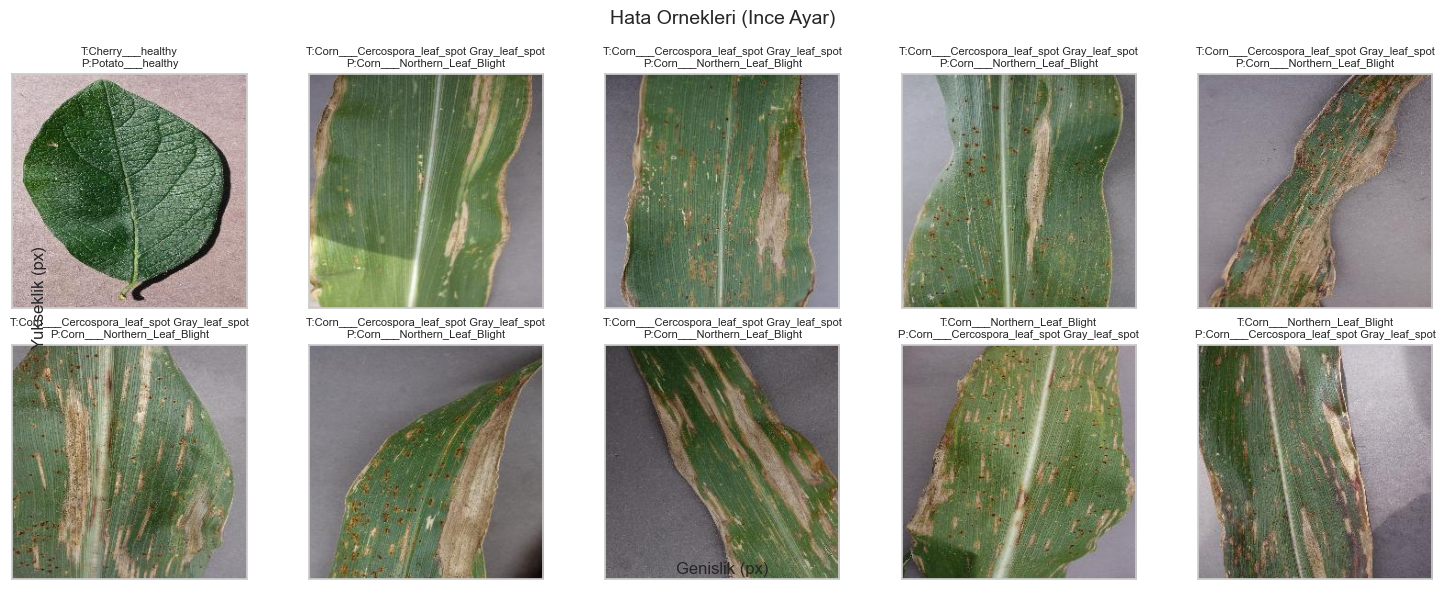

In [29]:
def plot_failure_grid(samples, y_true_arr, y_pred_arr, class_names, max_images=10):
    mis_idx = np.where(y_true_arr != y_pred_arr)[0][:max_images]
    if len(mis_idx) == 0:
        return
    cols = 5
    rows = int(np.ceil(len(mis_idx) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.array(axes).reshape(-1)
    for ax, idx in zip(axes, mis_idx):
        img_path, _ = samples[idx]
        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.set_title(
            f"T:{class_names[y_true_arr[idx]]}\nP:{class_names[y_pred_arr[idx]]}",
            fontsize=8,
        )
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axes[len(mis_idx) :]:
        ax.axis("off")

    fig.suptitle("Hata Ornekleri (Ince Ayar)", fontsize=14)
    fig.text(0.5, 0.04, "Genislik (px)", ha="center")
    fig.text(0.04, 0.5, "Yukseklik (px)", va="center", rotation="vertical")
    plt.tight_layout()
    plt.show()


plot_failure_grid(test_loader_ft.dataset.samples, y_true_ft, y_pred_ft, class_names)


Hata ornekleri, modelin zorlandigi goruntu kosullarini gorsellestirir. `plot_failure_grid` fonksiyonu icinde `numpy.where` ile yanlislar bulunuyor, `PIL` ile resimler okunup `matplotlib` ile grid ciziliyor. Goruntulerde ortak ozellikler (dusuk kontrast, benzer doku, arka plan karmasikligi) varsa bu bilgiler bir sonraki iyilestirme adimi icin cok degerli.


## 9. Tartisma ve Yorum
Buradaki sonuclar bana sunu gosterdi: klasik HOG+SVM hizli bir temel olusturdu ama siniflar arasinda dengesiz performans verdi. Transfer ogrenme ile makro F1 belirgin sekilde artti; ince ayar ekstra kazanc getirdi. Hata orneklerinde gorundugu gibi benzer doku ve arka plan etkisi model kararlarini zorlastiriyor. Sinirlamalarim: veri dengesizligi, farkli kamera/isitik kosullari ve sinif benzerligi. Bu yuzden ileride daha guclu veri arttirma, agirlikli kayip ve belki daha derin/dikkat tabanli mimari denemek mantikli olur.


## 10. Sonuc
Bu calisma, PlantVillage veri seti uzerinde klasik ve derin ogrenme yaklasimlarini karsilastirarak uctan uca bir siniflandirma boru hatti sunmustur. Kendi acimdan en onemli cikarim, veri kalite kontrolu ve veri hazirlamanin model kadar kritik oldugu.

**Ozet**
- HOG+SVM hizli ve yorumlanabilir bir referans sundu ancak derin ogrenmenin gerisinde kaldi.
- ResNet-18 transfer ogrenme + ince ayar, daha yuksek ve daha dengeli performans verdi.
- Metrikler sadece accuracy degil, makro F1 gibi sinif dengesini yansitan olculerle de yorumlanmali.

**Gercek dunya kullanimlari**
- Tarla izleme ve erken hastalik tespiti
- Mobil uygulamalar ile ciftci destek sistemleri
- Ziraat muhendisligi icin karar destek altyapisi
